In [27]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d


C:\Users\domin\AppData\Local\Temp\ipykernel_25696\2285119196.py:9: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [28]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")

In [29]:
train['date'] = pd.to_datetime(train['date']).dt.to_period('D')
#train = train.set_index('date') 



In [30]:
train.head(18)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype    
---  ------    --------------   -----    
 0   id        136950 non-null  int64    
 1   date      136950 non-null  period[D]
 2   country   136950 non-null  object   
 3   store     136950 non-null  object   
 4   product   136950 non-null  object   
 5   num_sold  136950 non-null  int64    
dtypes: int64(2), object(3), period[D](1)
memory usage: 6.3+ MB


In [32]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Enc_col = ['country', 'store', 'product' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: country
  Wartość zakodowana: 0 -> Wartość początkowa: Argentina
  Wartość zakodowana: 1 -> Wartość początkowa: Canada
  Wartość zakodowana: 2 -> Wartość początkowa: Estonia
  Wartość zakodowana: 3 -> Wartość początkowa: Japan
  Wartość zakodowana: 4 -> Wartość początkowa: Spain
Kolumna: store
  Wartość zakodowana: 0 -> Wartość początkowa: Kagglazon
  Wartość zakodowana: 1 -> Wartość początkowa: Kaggle Learn
  Wartość zakodowana: 2 -> Wartość początkowa: Kaggle Store
Kolumna: product
  Wartość zakodowana: 0 -> Wartość początkowa: Using LLMs to Improve Your Coding
  Wartość zakodowana: 1 -> Wartość początkowa: Using LLMs to Train More LLMs
  Wartość zakodowana: 2 -> Wartość początkowa: Using LLMs to Win Friends and Influence People
  Wartość zakodowana: 3 -> Wartość początkowa: Using LLMs to Win More Kaggle Competitions
  Wartość zakodowana: 4 -> Wartość początkowa: Using LLMs to Write Better


In [33]:
train = train.drop(columns=['country', 'store', 'product'])
Argentina  = train[train['country_Enc'] == 0]
Canada     = train[train['country_Enc'] == 1]
Estonia    = train[train['country_Enc'] == 2]
Japan      = train[train['country_Enc'] == 3]
Japan      = train[train['country_Enc'] == 4]
Argentina  = Argentina.drop(columns= 'country_Enc')

In [34]:
Argentina.head()

,id,date,num_sold,store_Enc,product_Enc
0,0,2017-01-01,63,1.0,0.0
1,1,2017-01-01,66,1.0,1.0
2,2,2017-01-01,9,1.0,2.0
3,3,2017-01-01,59,1.0,3.0
4,4,2017-01-01,49,1.0,4.0


In [35]:
multi_index = pd.MultiIndex.from_frame(Argentina[['date' , 'id']], names =  ['date' , 'id'])
Argentina.set_index(multi_index, inplace=True)
Argentina = Argentina.drop(columns=['id', 'date'])

In [36]:
import itertools

store_codes = Argentina['store_Enc'].unique()
product_codes = Argentina['product_Enc'].unique()

# Filter valid combinations based on existing data
valid_combos = [(s, p) for s in store_codes for p in product_codes]
# Create new column names from the valid combinations
new_column_names = [f'store_{s}_product_{p}' for s, p in valid_combos]
combo_df = pd.DataFrame(columns=new_column_names)

def fill_values(argentina_df, combine_df, target_cols=None):
  num_sold_values = argentina_df['num_sold'].values

  # Calculate the required number of rows
  num_rows = len(num_sold_values) // len(combine_df.columns)
  if len(num_sold_values) % len(combine_df.columns) != 0:
    raise ValueError("Number of 'num_sold' values not evenly divisible by number of columns in combo_df")

  # Create a new DataFrame with the required shape
  filled_df = pd.DataFrame(index=range(num_rows), columns=combine_df.columns)

  # Fill the values
  for row_num in range(num_rows):
    start_idx = row_num * len(combine_df.columns)
    end_idx = start_idx + len(combine_df.columns)
    if target_cols is None:
      filled_df.iloc[row_num, :] = num_sold_values[start_idx:end_idx]
    else:
      for col in target_cols:
        if col in combine_df.columns:
          filled_df.loc[row_num, col] = num_sold_values[start_idx:end_idx]
        else:
          print(f"Column '{col}' not found in combo_df")

  return filled_df

# Call the function and assign the result to 'df'
df = fill_values(Argentina, combo_df)


df.index = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
df = df.apply(pd.to_numeric, errors='coerce')
df = df.select_dtypes(include=['number']).astype('int32')

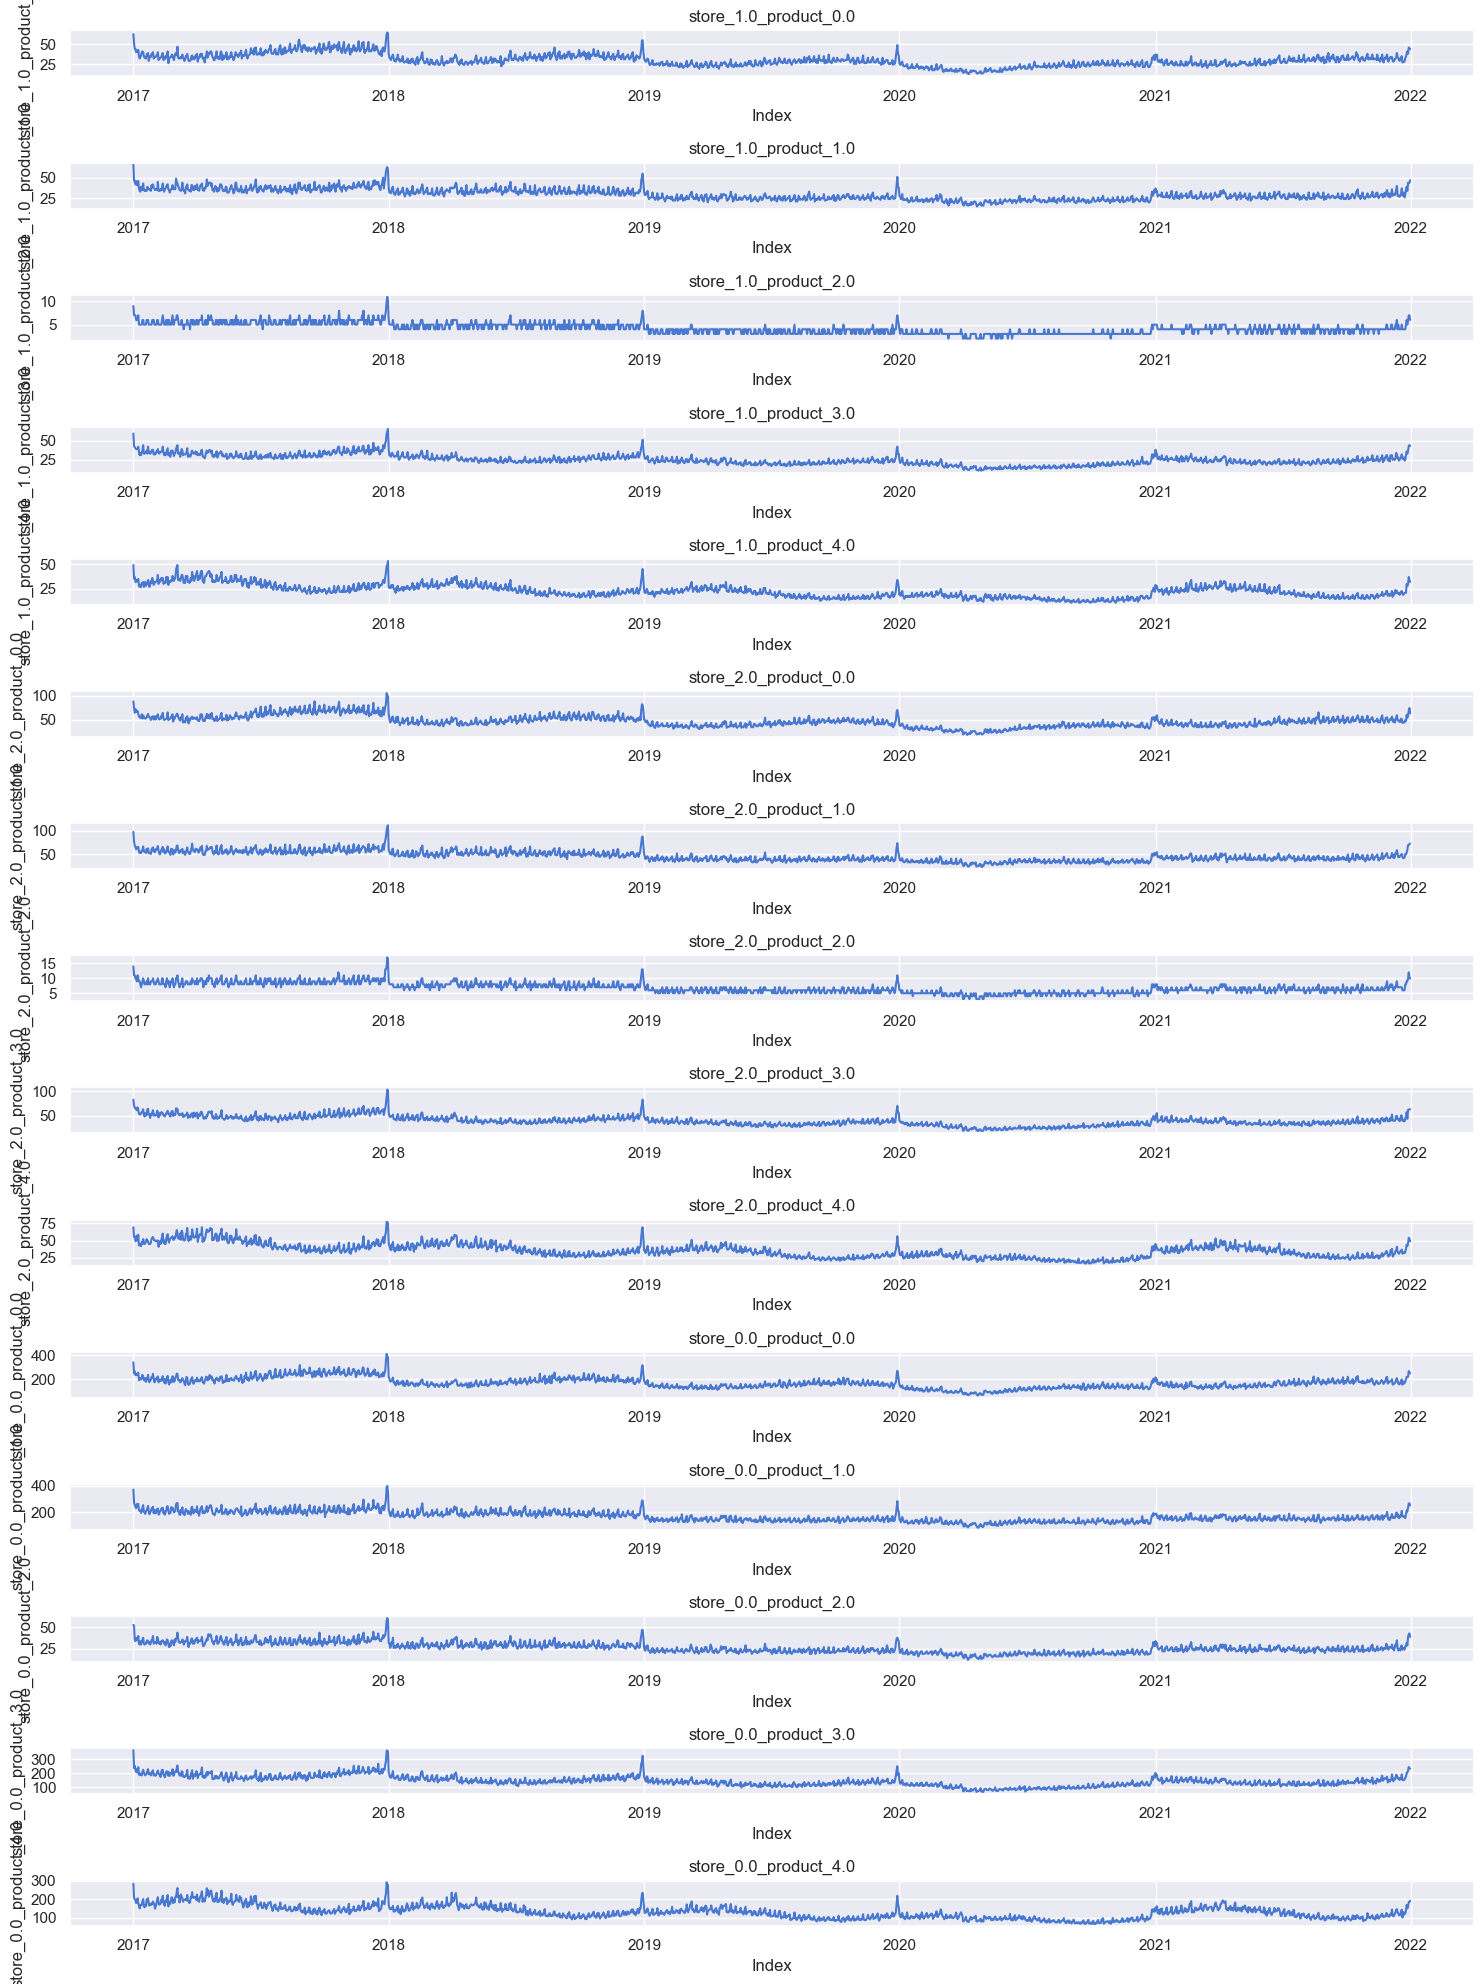

In [37]:
fig, axes = plt.subplots(len(df.columns), 1, figsize=(15, 20))

# Iterate over columns and create line charts
for i, (col, ax) in enumerate(zip(df.columns, axes.flat)):
  sns.lineplot(x=df.index, y=df[col], ax=ax)
  ax.set_title(col)
  ax.set_xlabel('Index')
  ax.set_ylabel(col)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

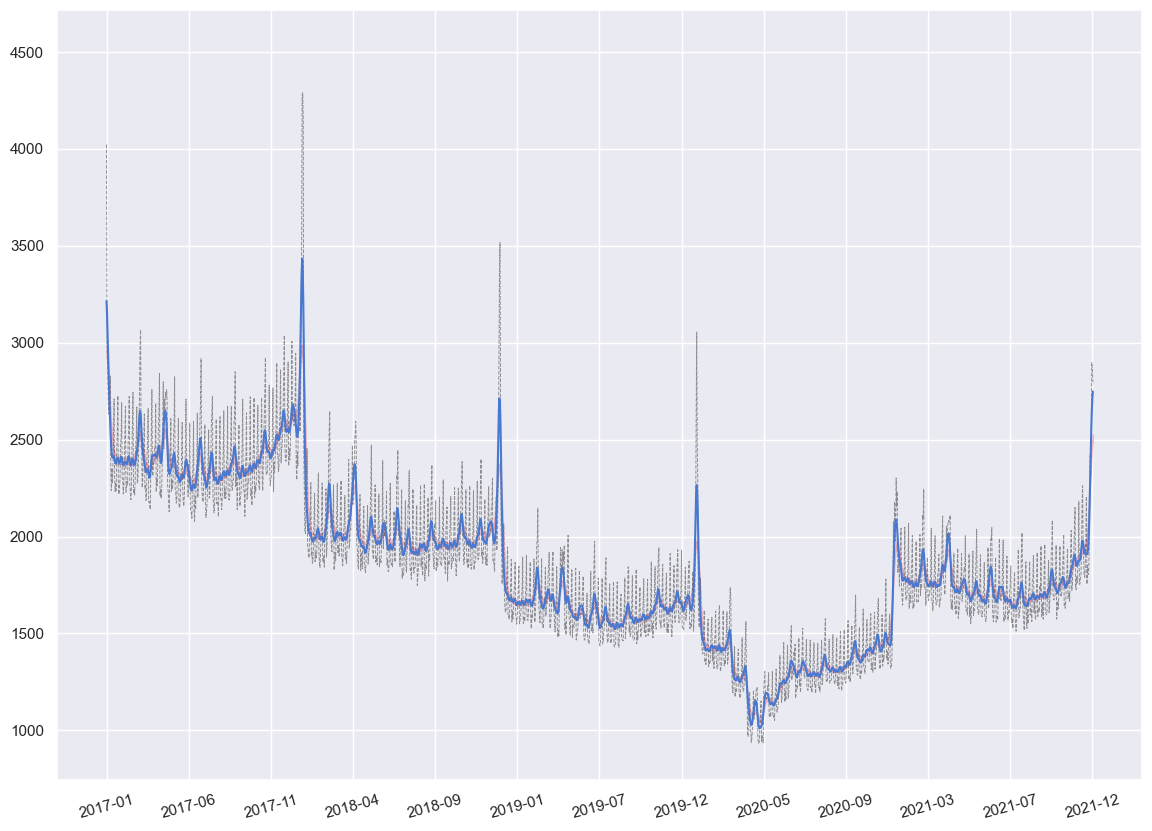

In [42]:
# Calculate the row-wise sum without assigning to a named Series
row_sums = df.sum(axis=1)
df['Total'] = row_sums
df.head()

# sns.set(style="darkgrid", palette="muted", color_codes=True)
# fig, ax = plt.subplots(figsize=(14, 10))
# y_pos = np.arange(len(df['Total']))  # Use length of 'Total' column

# # Select 'Total' column for smoothing (assuming it's the first column)
# total_column = df['Total']

# # Apply Gaussian filter for smoothing
# Final_array_smooth = gaussian_filter1d(total_column.to_numpy(), sigma=2.5)

# # Error formatting (assuming 'Total' is the first column and errors are in subsequent columns)
# upper_err = gaussian_filter1d(total_column.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=5)
# lower_err = gaussian_filter1d(total_column.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=5)

# # Plot lines and shaded area
# ax.plot(y_pos, total_column, '--', linewidth=0.7, color='k', alpha=0.45)  # Plot original data
# ax.plot(y_pos, Final_array_smooth)  # Plot smoothed data
# ax.fill_between(y_pos, upper_err, lower_err, color='crimson', alpha=0.2)  # Plot error shade

# # Adjust y-axis limits based on 'Total' column
# ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
#             np.max(total_column) + (np.max(total_column) * 10) / 100)


# plt.show()



sns.set(style="darkgrid", palette="muted", color_codes=True)  # Use color_dates for automatic color mapping
fig, ax = plt.subplots(figsize=(14, 10))
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
total_column = df['Total']

# Align data and date range (if necessary)
if len(df) != len(date_range):
    df = df.reindex(date_range, fill_value=np.nan)  # Reindex to match date range

# Select data based on reindexed DataFrame (if necessary)
total_column = df['Total']

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(total_column.to_numpy(), sigma=2.5)

# Error formatting (assuming 'Total' is the first column and errors are in subsequent columns)
upper_err = gaussian_filter1d(total_column.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=5)
lower_err = gaussian_filter1d(total_column.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=5)

# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.7, color='k', alpha=0.45)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.2)  # Plot error shade with DateTimeIndex

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)


num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

In [39]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX


# Assuming 'train' is your DataFrame with 'num_sold_scaled' as the target variable
det_proc = DeterministicProcess(df.index, fourier=3)
det_proc.in_sample()


,"sin(1,7)","cos(1,7)","sin(2,7)","cos(2,7)","sin(3,7)","cos(3,7)"
2017-01-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2017-01-03,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-01-04,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-01-05,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
...,...,...,...,...,...,...
2021-12-27,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2021-12-28,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2021-12-29,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2021-12-30,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


In [40]:
train_with_exo = pd.concat([df['Total'], det_proc.in_sample()], axis=1)
model = SARIMAX(train_with_exo['Total'],
                     order=(2, 1, 2),  # Adjust order parameters as needed
                     seasonal_order=(1, 1, 1, 12),  # Adjust seasonal order as needed
                     exog=train_with_exo[['sin(1,7)', 'cos(1,7)',	'sin(2,7)',	'cos(2,7)',	'sin(3,7)',	'cos(3,7)']])
#
SARIMAX_fit = model.fit()
print(SARIMAX_fit.summary())

C:\Users\domin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                 1826
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -9353.365
Date:                              Mon, 13 May 2024   AIC                          18732.731
Time:                                      21:42:19   BIC                          18804.267
Sample:                                  01-01-2017   HQIC                         18759.128
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,7)     -42.4809      2.133    -19.914      0.000     -46.662     -38.300
cos(1,7)      64.88

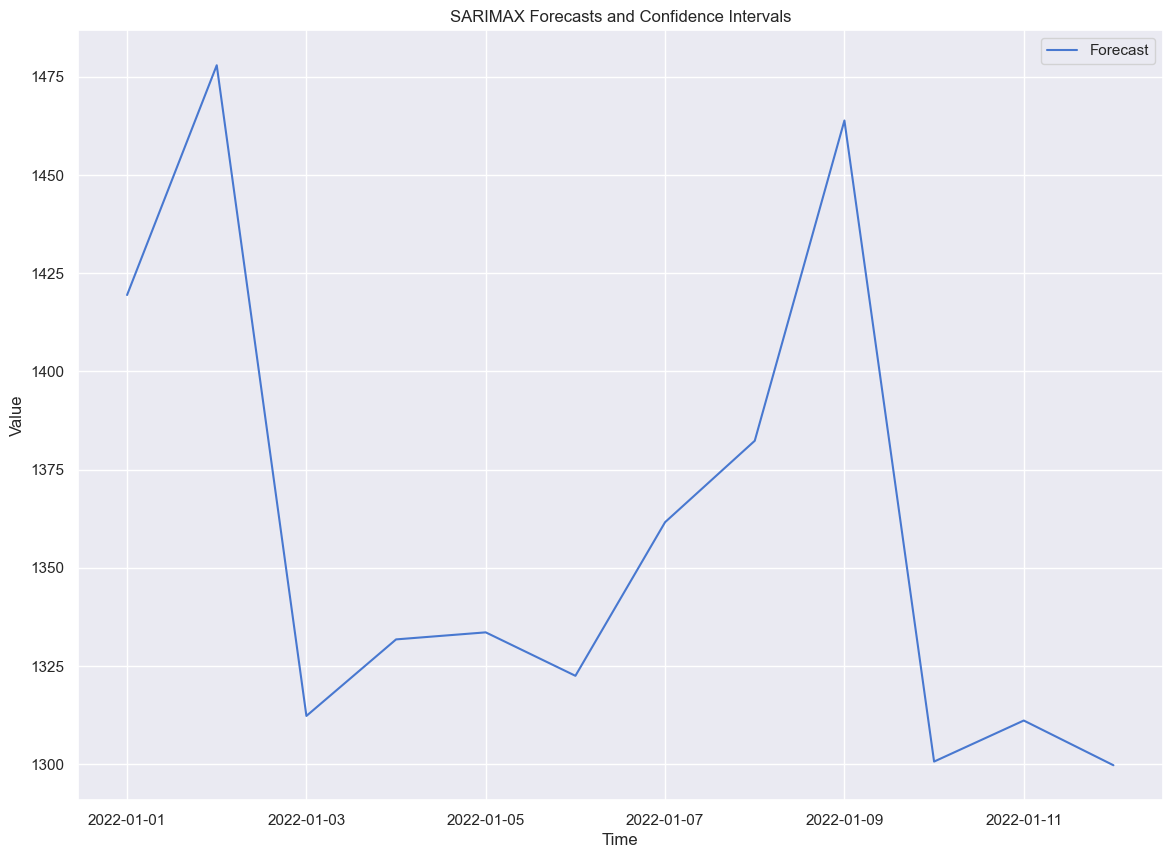

In [41]:
forecast_results = SARIMAX_fit.forecast(steps=12, exog=det_proc.out_of_sample(12))  # Forecast for 12 steps (e.g., 12 months)
forecast_df = pd.DataFrame(forecast_results)

# Plot forecasts and confidence intervals
plt.figure(figsize=(14, 10))
plt.plot(forecast_df.index, forecast_df['predicted_mean'], label='Forecast')  # Assuming the forecast column is named 'predicted'
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SARIMAX Forecasts and Confidence Intervals')
plt.show()